In [1]:
import os
import zipfile
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.io import loadmat
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import random
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

from collections import Counter

np.random.seed(42)

# UTILS

In [2]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    print('Number of samples', n_samples)
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels

def build_dataset_from_ninapro_subset(emg, stimulus, repetition, features, trials):
    """
    Build dataset and labels only for a specific subset of trials.
    'trials' is a list of (stimulus_idx, repetition_idx) tuples (1-based).
    """
    n_samples = len(trials)
    n_channels = emg.shape[1]
    n_features = sum(n_channels for _ in features)

    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)

    for sample_i, (stim_i, rep_i) in enumerate(trials):
        labels[sample_i] = stim_i
        selected_tsteps = np.logical_and(stimulus == stim_i, repetition == rep_i).squeeze()
        current_feature_index = 0
        for feature in features:
            selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
            dataset[sample_i, selected_features] = feature(emg[selected_tsteps, :])
            current_feature_index += n_channels

    return dataset, labels

def plot_emg_and_envelopes(emg_windows, emg_envelopes, tuples_list, n_repetitions):

    for stimulus_idx, channel_idx in tuples_list:
        # Créer la figure avec deux sous-graphiques
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # --- Graphique 1 : Signaux bruts ---
        for repetition_idx in range(n_repetitions):
            emg_trial = emg_windows[stimulus_idx - 1][repetition_idx]  # stimulus_idx - 1 pour l'indexation
            if emg_trial is not None:  # Vérifie que le trial existe
                axes[0].plot(emg_trial[:, channel_idx - 1], alpha=0.6, label=f"Repetition {repetition_idx + 1}")
        
        axes[0].set_title(f"Stimulus {stimulus_idx} - Channel {channel_idx} - Raw EMG Signals")
        axes[0].set_xlabel("Time (samples)")
        axes[0].set_ylabel(f"Raw EMG Amplitude (Channel {channel_idx})")
        axes[0].legend(title="Repetitions", loc="upper right")
        
        # --- Graphique 2 : Signaux lissés/enveloppes ---
        for repetition_idx in range(n_repetitions):
            emg_envelope = emg_envelopes[stimulus_idx - 1][repetition_idx]
            if emg_envelope is not None:  # Vérifie que le trial existe
                axes[1].plot(emg_envelope[:, channel_idx - 1], alpha=0.6, label=f"Repetition {repetition_idx + 1}")
        
        axes[1].set_title(f"Stimulus {stimulus_idx} - Channel {channel_idx} - EMG Envelopes")
        axes[1].set_xlabel("Time (samples)")
        axes[1].set_ylabel(f"Smoothed EMG Amplitude (Channel {channel_idx})")
        axes[1].legend(title="Repetitions", loc="upper right")
        
        # Ajuster la mise en page
        plt.tight_layout()
        plt.show()


# 1. Load and preprocess the data

In [3]:
data_dir = "s2"
file_name = "S2_A1_E1.mat"
file_path = os.path.join(data_dir, file_name)

if os.path.isfile(file_path):
    mat = scipy.io.loadmat(file_path)
    print("File loaded successfully.")

else:
    print(f"The field {file_path} does not exist.")

print(mat.keys())

File loaded successfully.
dict_keys(['__header__', '__version__', '__globals__', 'subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition'])


In [4]:
mat['emg'].shape

(100686, 10)

In [5]:
emg = mat["emg"]
print("EMG data dimension: {}".format(emg.shape))
print("EMG data type: {}".format(type(emg)))
stimulus = mat['restimulus']
repetition = mat['rerepetition']

EMG data dimension: (100686, 10)
EMG data type: <class 'numpy.ndarray'>


In [6]:
n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
print('Number of stimuli', n_stimuli)
n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition
print('Number of repetitions', n_repetitions)

mov_mean_length = 40 #??????????????????????????????????????????
mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length
    
#initializing the data structure
emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    
for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
        emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
        emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)
print(emg_envelopes[0][0].shape)

Number of stimuli 12
Number of repetitions 10
(307, 10)


# 2. Visualize the data

We start by checking if there are any constant signals (bad trials) that we would need to remove.

In [7]:
def is_constant(signal):
    return np.var(signal) == 0  
    
constant_signals = {"raw": [], "envelope": []}

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        emg_trial = emg_windows[stimuli_idx][repetition_idx]
        if emg_trial is not None:
            for channel_idx in range(emg_trial.shape[1]):
                if is_constant(emg_trial[:, channel_idx]):
                    constant_signals["raw"].append((stimuli_idx + 1, repetition_idx + 1, channel_idx + 1))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        emg_envelope = emg_envelopes[stimuli_idx][repetition_idx]
        if emg_envelope is not None:
            for channel_idx in range(emg_envelope.shape[1]):
                if is_constant(emg_envelope[:, channel_idx]):
                    constant_signals["envelope"].append((stimuli_idx + 1, repetition_idx + 1, channel_idx + 1))

print("\n=== Constant signals detected ===")
if constant_signals["raw"]:
    print("Raw signals:")
    for stim, rep, chan in constant_signals["raw"]:
        print(f"Stimulus {stim}, Répétition {rep}, Canal {chan}")
else:
    print("No constant signal detected in raw signals.")

if constant_signals["envelope"]:
    print("\nSmoothed signals (envelopes):")
    for stim, rep, chan in constant_signals["envelope"]:
        print(f"Stimulus {stim}, Répétition {rep}, Canal {chan}")
else:
    print("No constant signal detected in smoothed signals.")


=== Constant signals detected ===
No constant signal detected in raw signals.
No constant signal detected in smoothed signals.


Here is the power spectral density (PSD) of the EMG signal to see where the energy of the signal is concentrated for each channel.

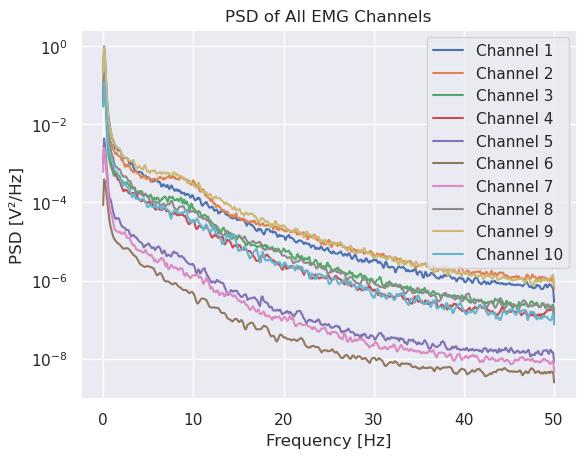

In [8]:
number_channels = emg.shape[1]
fs = 100 # found in paper

for i in range(number_channels):
    freqs, psd = welch(emg[:, i], fs=fs, nperseg=1024)
    plt.semilogy(freqs, psd, label=f'Channel {i+1}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V²/Hz]')
plt.title('PSD of All EMG Channels')
plt.legend()
plt.show()

Now we will look at the average activation for each stimulus, taking into account the different channels and repetitions.

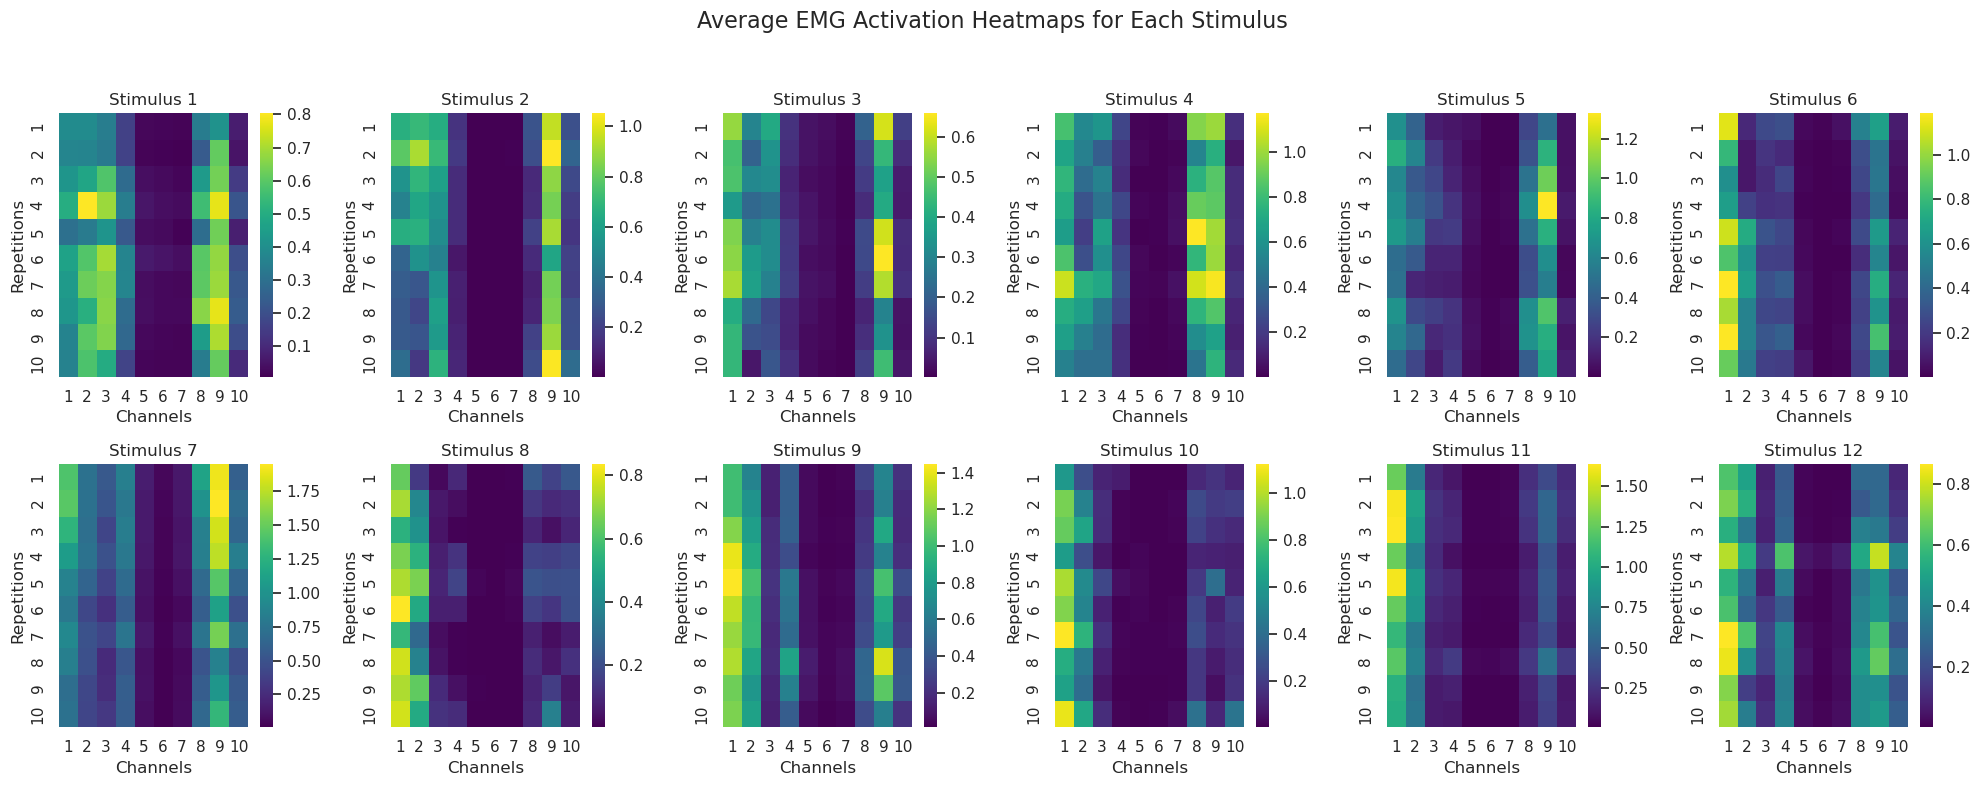

In [9]:
# Compute the average EMG activation per repetition and per channel
average_emg = np.zeros((n_stimuli, n_repetitions, emg.shape[1]))  # shape: (stimulus, repetition, channels)

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):
        # Compute the mean for each channel in the current envelope
        average_emg[stimuli_idx, repetition_idx, :] = np.mean(emg_envelopes[stimuli_idx][repetition_idx], axis=0)

# Plot all heatmaps in one figure (2 rows, 6 columns)
fig, axes = plt.subplots(2, 6, figsize=(20, 8))
fig.suptitle("Average EMG Activation Heatmaps for Each Stimulus", fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

for stimuli_idx in range(n_stimuli):
    sns.heatmap(average_emg[stimuli_idx], annot=False, fmt=".2f", cmap="viridis",
                xticklabels=[f"{c+1}" for c in range(emg.shape[1])],
                yticklabels=[f"{r+1}" for r in range(n_repetitions)],
                ax=axes[stimuli_idx])
    axes[stimuli_idx].set_title(f"Stimulus {stimuli_idx + 1}")
    axes[stimuli_idx].set_xlabel("Channels")
    axes[stimuli_idx].set_ylabel("Repetitions")

# Remove any unused axes (in case of fewer stimuli)
for i in range(n_stimuli, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

Then we decided to visualize the EMG signals for all repetitions of all stimuli in channel 0 to have an idea of what the signals look like.

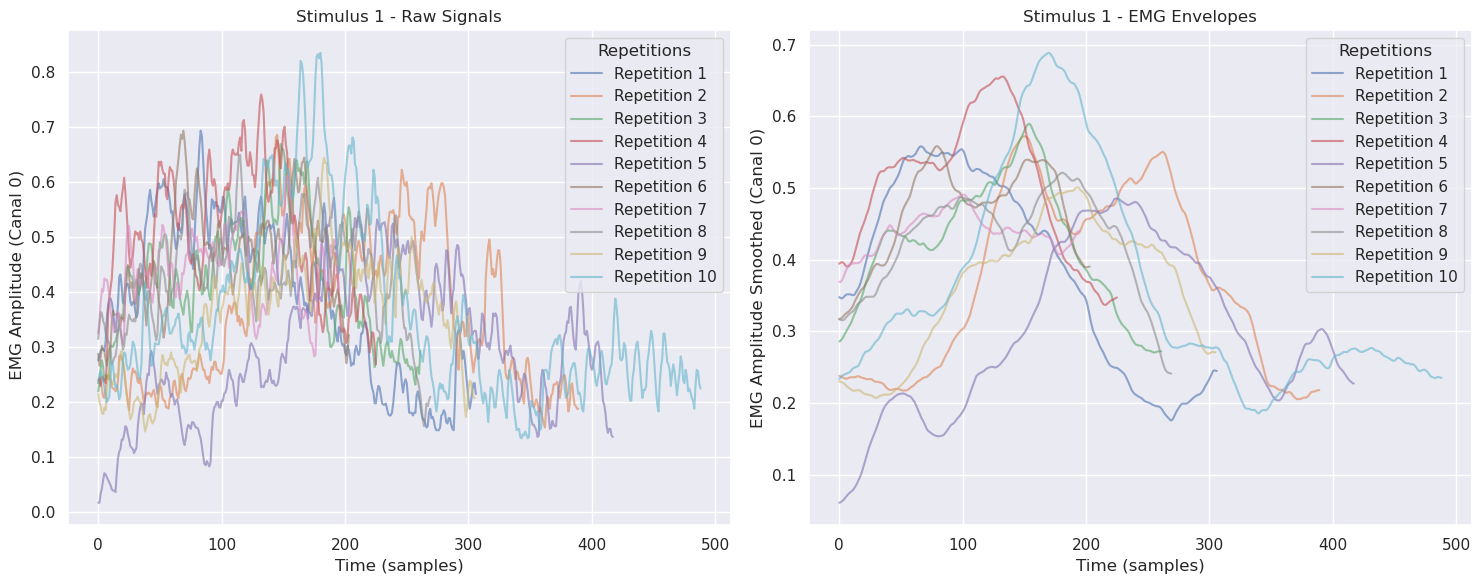

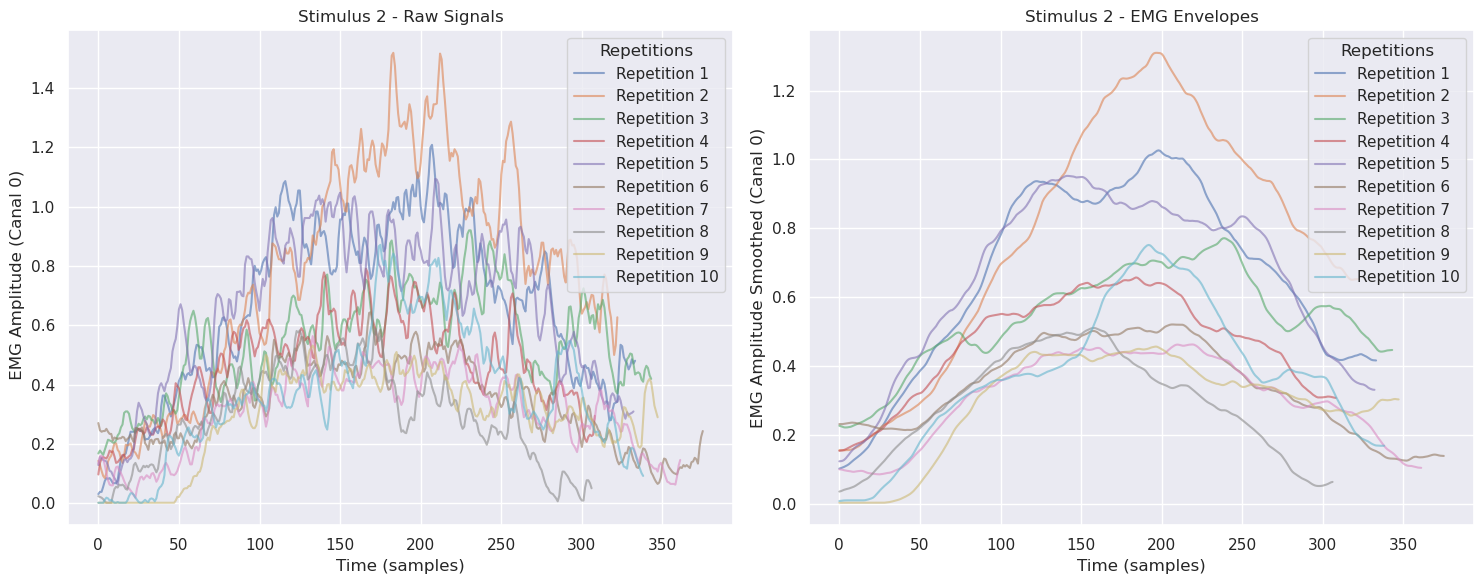

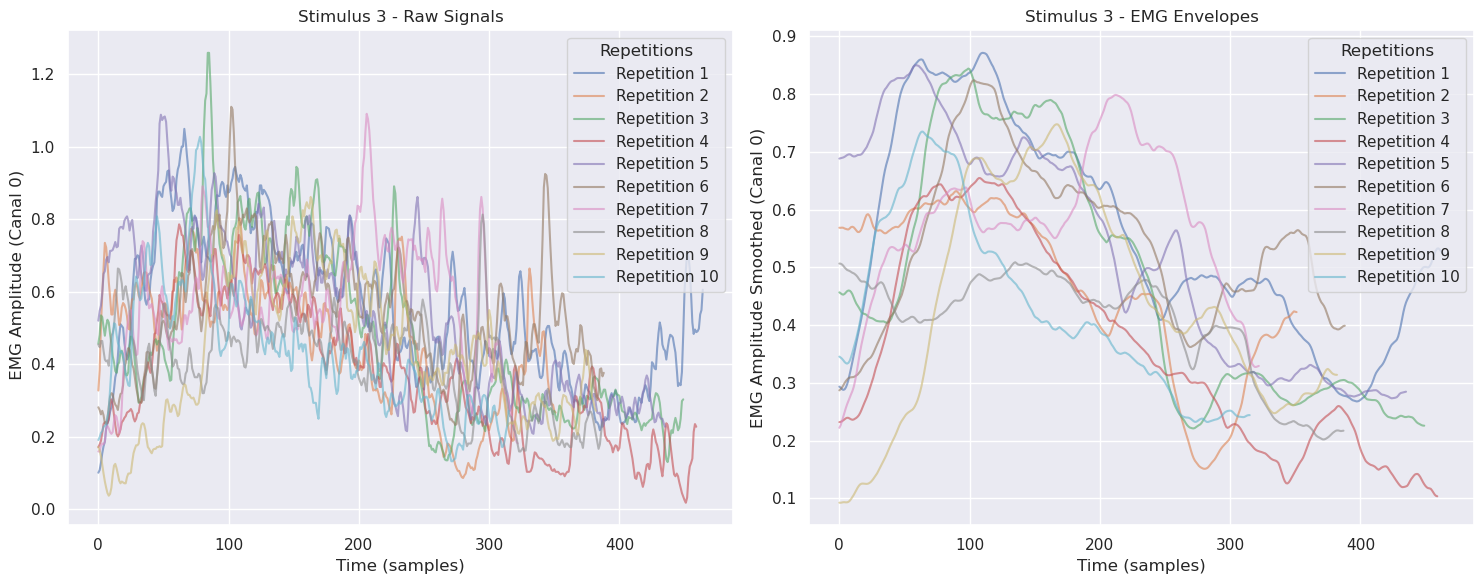

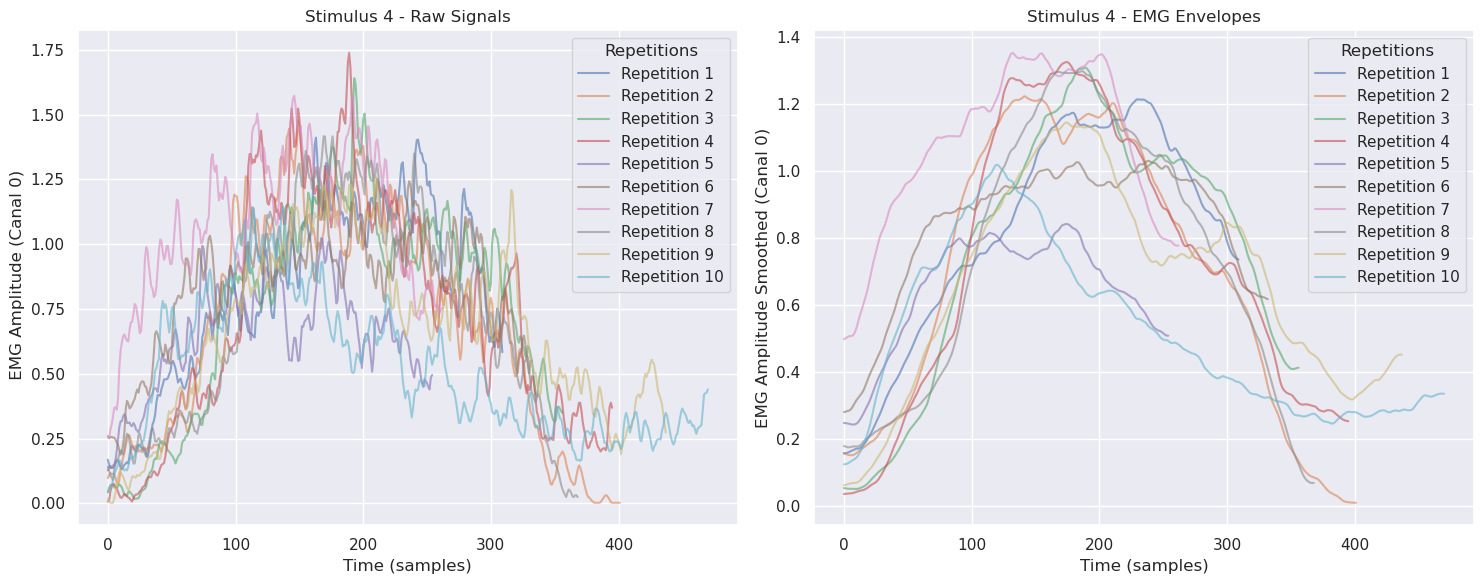

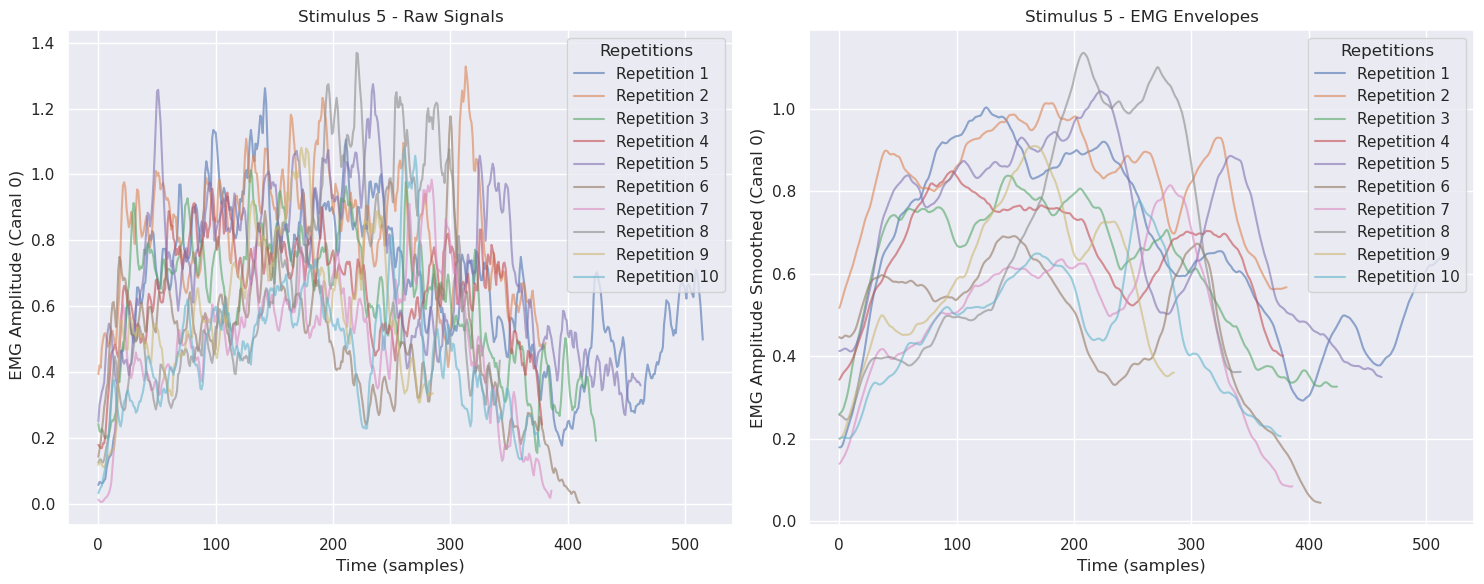

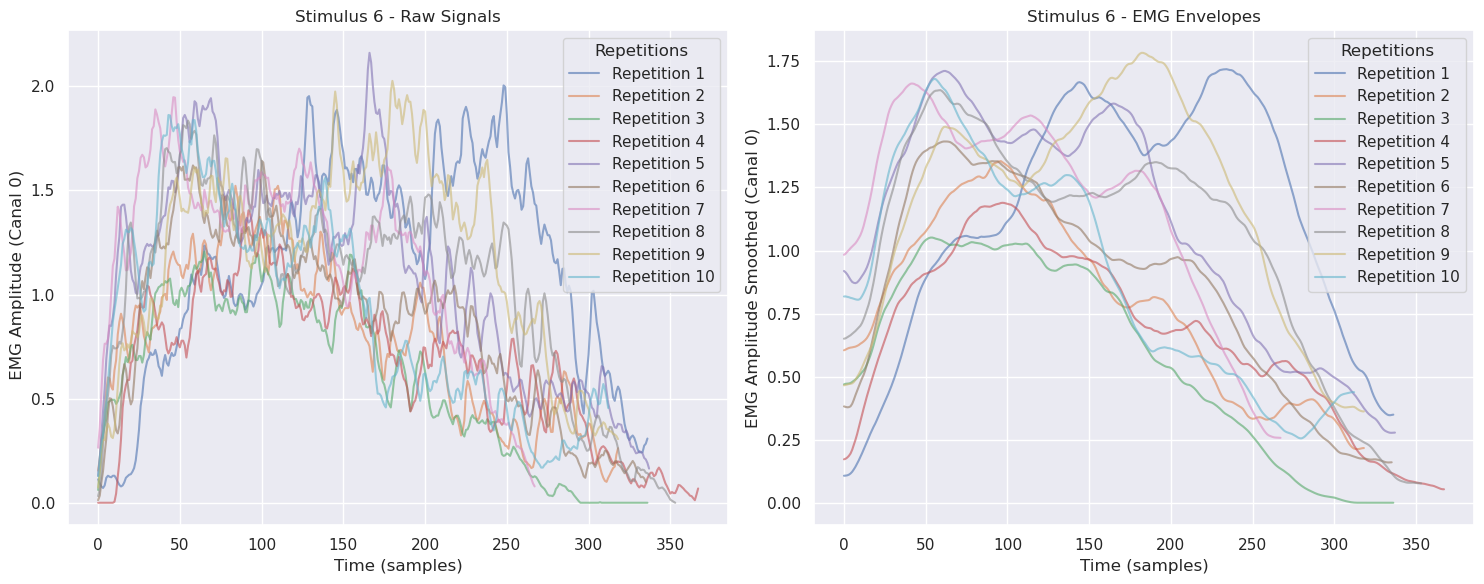

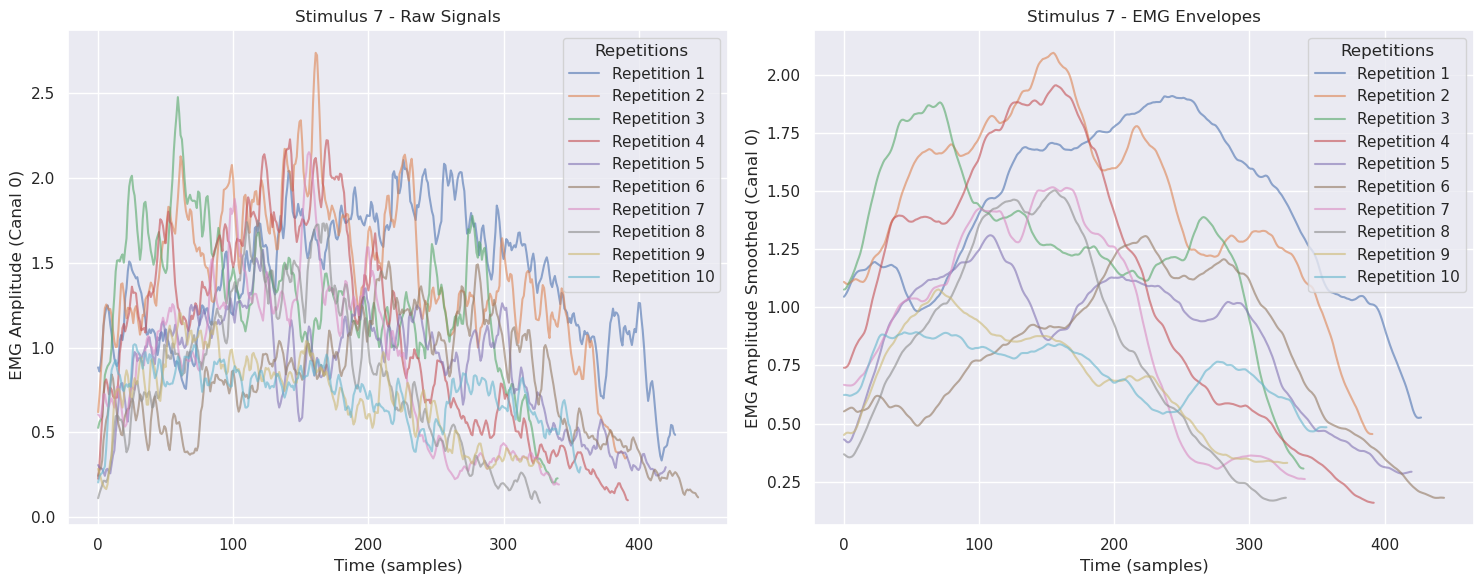

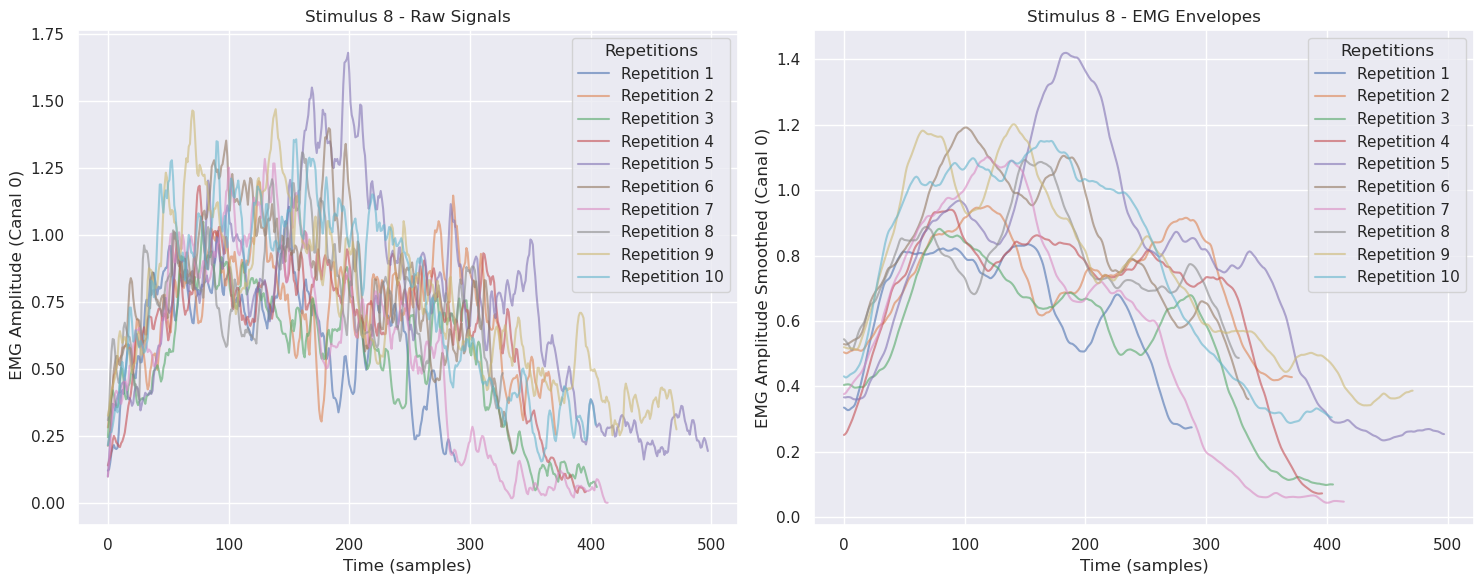

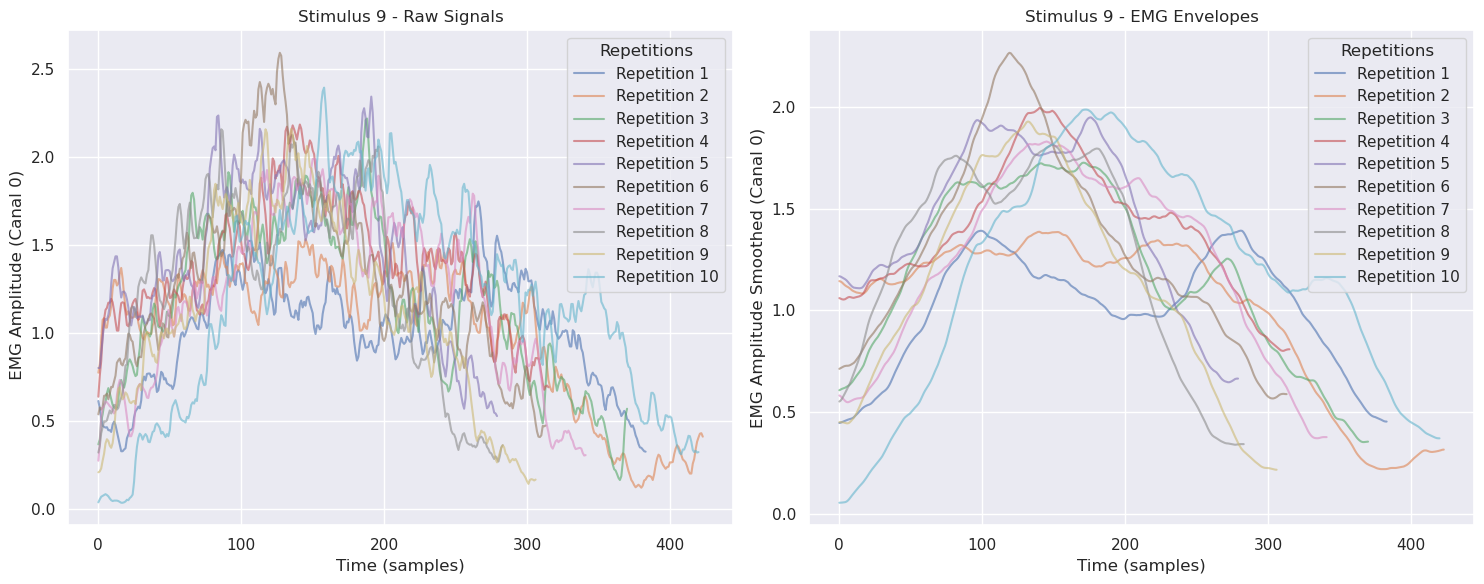

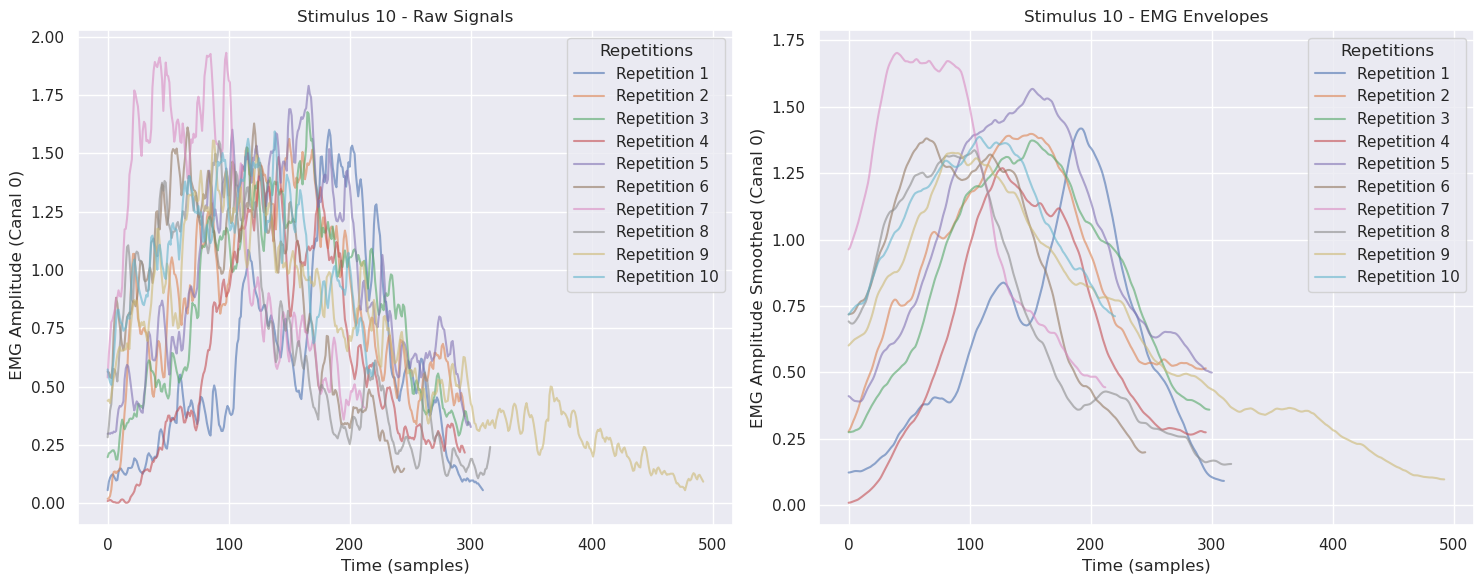

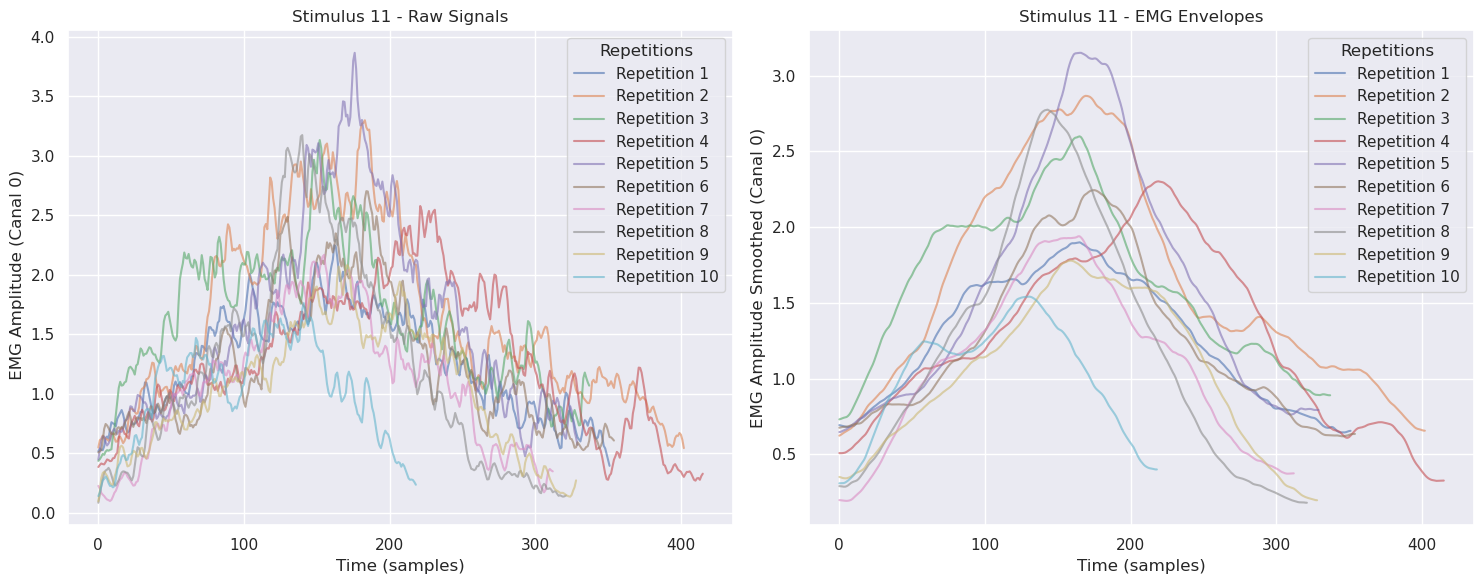

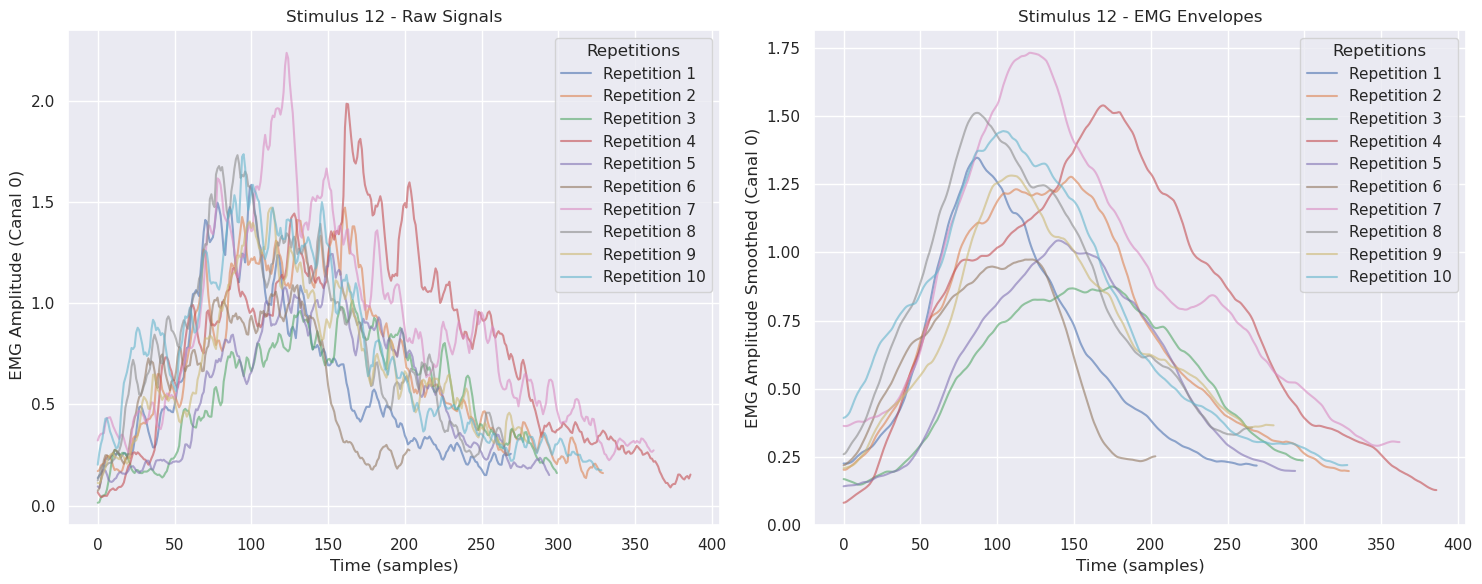

In [10]:
# Visualisation des signaux bruts et lissés côte à côte
for stimuli_idx in range(n_stimuli):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Deux graphiques côte à côte
    
    # --- Graphique 1 : Signaux bruts (emg_windows) ---
    for repetition_idx in range(n_repetitions):
        emg_trial = emg_windows[stimuli_idx][repetition_idx]
        
        if emg_trial is not None:  # Vérifie que le trial existe
            axes[0].plot(emg_trial[:, 0], alpha=0.6, label=f"Repetition {repetition_idx + 1}")
    
    axes[0].set_title(f"Stimulus {stimuli_idx + 1} - Raw Signals")
    axes[0].set_xlabel("Time (samples)")
    axes[0].set_ylabel(" EMG Amplitude (Canal 0)")
    axes[0].legend(title="Repetitions", loc="upper right")
    
    # --- Graphique 2 : Signaux lissés/enveloppes (emg_envelopes) ---
    for repetition_idx in range(n_repetitions):
        emg_envelope = emg_envelopes[stimuli_idx][repetition_idx]
        
        if emg_envelope is not None:  # Vérifie que le trial existe
            axes[1].plot(emg_envelope[:, 0], alpha=0.6, label=f"Repetition {repetition_idx + 1}")
    
    axes[1].set_title(f"Stimulus {stimuli_idx + 1} - EMG Envelopes")
    axes[1].set_xlabel("Time (samples)")
    axes[1].set_ylabel("EMG Amplitude Smoothed (Canal 0)")
    axes[1].legend(title="Repetitions", loc="upper right")
    
    # Afficher les deux graphiques côte à côte
    plt.tight_layout()
    plt.show()


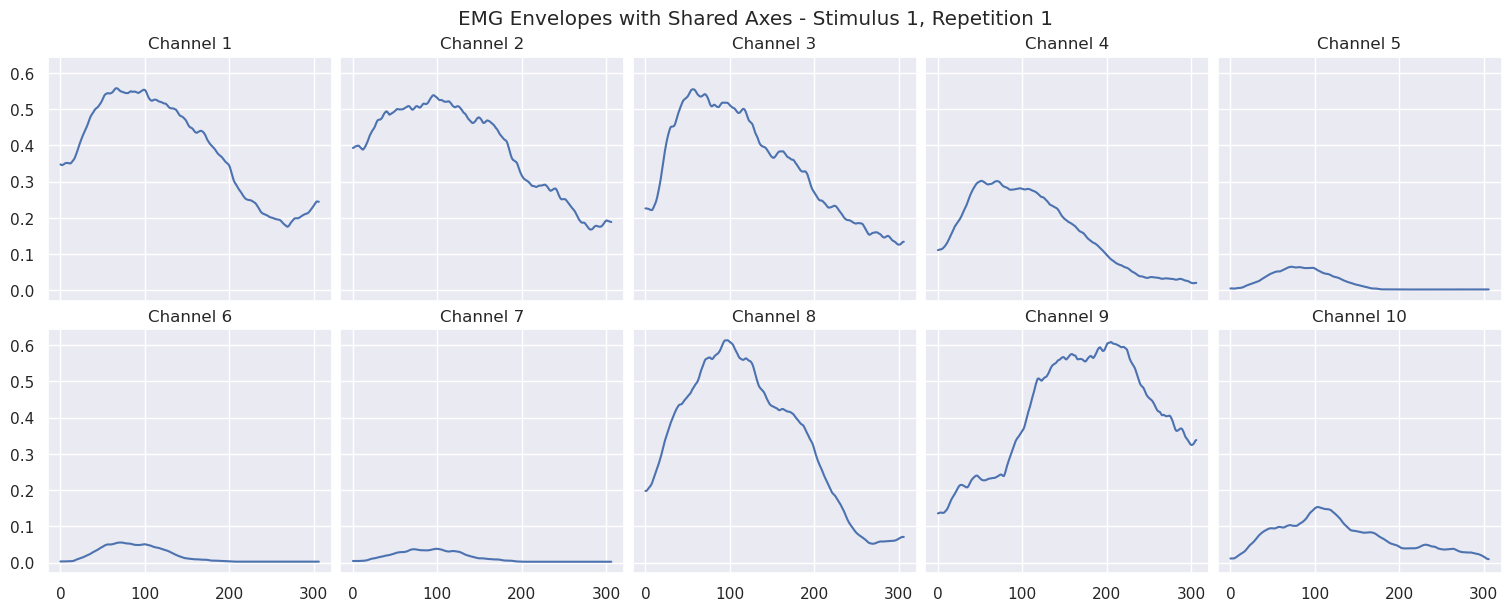

In [11]:
# Shared axes to compare across channels

fig, ax = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True, sharex=True, sharey=True)
ax = ax.ravel()

for channel_idx in range(number_channels):
    ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
    ax[channel_idx].set_title(f"Channel {channel_idx + 1}")
plt.suptitle("EMG Envelopes with Shared Axes - Stimulus 1, Repetition 1")
plt.show()

Here we decided to look at the signals for all the repetitions of all the stimuli in channel 0 t0 have an idea of how the signals look like.

# 3. Compute and visualize the features

In [12]:
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

features = [mav, std, maxav, rms, wl, ssc]

# splitting step BEFORE feature extraction:
# Create a list of all trials (stimulus, repetition)
trials = [(i+1, j+1) for i in range(n_stimuli) for j in range(n_repetitions)]
labels_for_trials = [trial[0] for trial in trials]

X_train_trials, X_test_trials = train_test_split(
    trials, test_size=0.3, random_state=42, stratify=labels_for_trials
)

# Build the training and testing datasets
X_train, y_train = build_dataset_from_ninapro_subset(emg, stimulus, repetition, features, X_train_trials)
X_test, y_test = build_dataset_from_ninapro_subset(emg, stimulus, repetition, features, X_test_trials)

# dimensions of the dataset : (12 stimuli * 10 repetitions, 6 features * 10 channels)
print(f"Train: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test: {X_test.shape}, Labels: {y_test.shape}")

Train: (84, 60), Labels: (84,)
Test: (36, 60), Labels: (36,)


In [13]:
def assess_class_distribution(labels):
    class_counts = Counter(labels)
    total = len(labels)
    print("Class Distribution:")
    for cls, count in class_counts.items():
        percentage = (count / total) * 100
        print(f"Class {cls}: {count} samples ({percentage:.2f}%)")
    print()

# Assess class distribution
print("Training set class distribution:")
assess_class_distribution(y_train)

print("Test set class distribution:")
assess_class_distribution(y_test)

Training set class distribution:
Class Distribution:
Class 4.0: 7 samples (8.33%)
Class 6.0: 7 samples (8.33%)
Class 8.0: 7 samples (8.33%)
Class 12.0: 7 samples (8.33%)
Class 9.0: 7 samples (8.33%)
Class 3.0: 7 samples (8.33%)
Class 11.0: 7 samples (8.33%)
Class 10.0: 7 samples (8.33%)
Class 5.0: 7 samples (8.33%)
Class 2.0: 7 samples (8.33%)
Class 1.0: 7 samples (8.33%)
Class 7.0: 7 samples (8.33%)

Test set class distribution:
Class Distribution:
Class 11.0: 3 samples (8.33%)
Class 3.0: 3 samples (8.33%)
Class 5.0: 3 samples (8.33%)
Class 2.0: 3 samples (8.33%)
Class 4.0: 3 samples (8.33%)
Class 12.0: 3 samples (8.33%)
Class 8.0: 3 samples (8.33%)
Class 1.0: 3 samples (8.33%)
Class 9.0: 3 samples (8.33%)
Class 6.0: 3 samples (8.33%)
Class 7.0: 3 samples (8.33%)
Class 10.0: 3 samples (8.33%)



To further verify if there might be some bad trials within the data, we will plot the variance of one feature within the repetitions of 1 stimulus in 1 channel.
We will then plot the signals of the combinations (stimulus, channel) with highest variability, to make sure that this variability is not due to bad trials.

In addition, for each feature we plot the mean over all repetitions to look at the typical values of the features across the different trials

Number of samples 120

Top 3 combinations with highest variability for feature 'MAV':
1. Stimulus 7, Channel 10, Variance: 188.0000
2. Stimulus 5, Channel 10, Variance: 136.8500
3. Stimulus 12, Channel 10, Variance: 97.6400


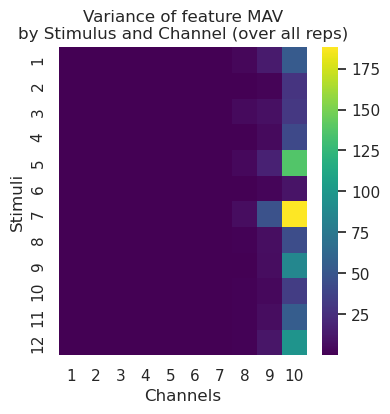

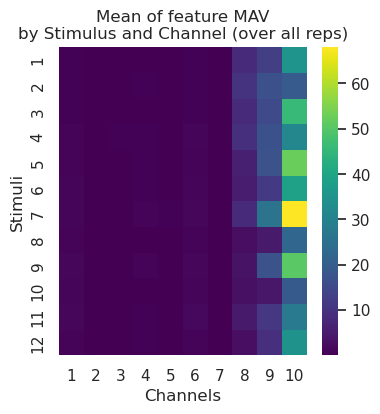


Top 3 combinations with highest variability for feature 'STD':
1. Stimulus 7, Channel 10, Variance: 86.0400
2. Stimulus 12, Channel 10, Variance: 58.6900
3. Stimulus 9, Channel 10, Variance: 37.8000


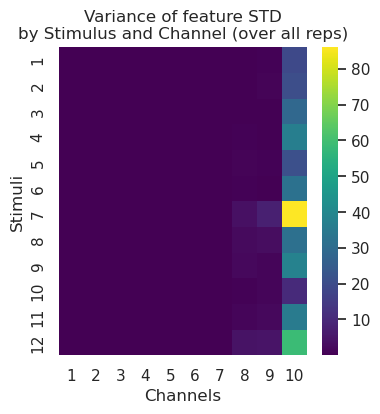

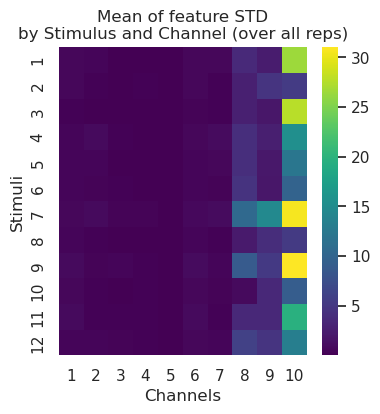


Top 3 combinations with highest variability for feature 'MaxAV':
1. Stimulus 10, Channel 9, Variance: 711.9600
2. Stimulus 1, Channel 9, Variance: 616.3600
3. Stimulus 11, Channel 9, Variance: 429.6400


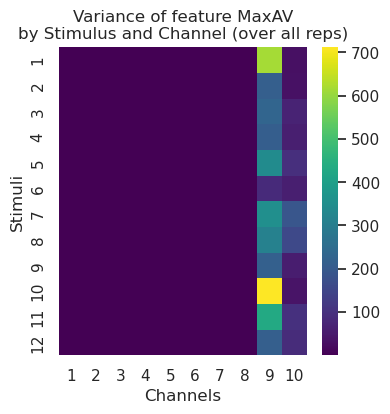

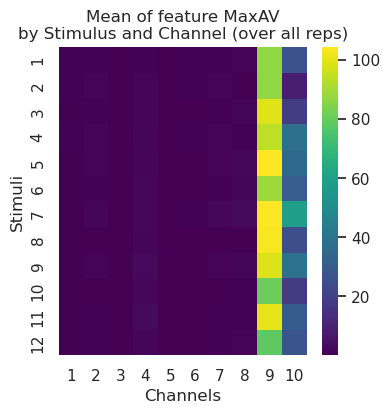


Top 3 combinations with highest variability for feature 'RMS':
1. Stimulus 8, Channel 9, Variance: 777.3600
2. Stimulus 10, Channel 9, Variance: 733.2900
3. Stimulus 5, Channel 9, Variance: 556.2900


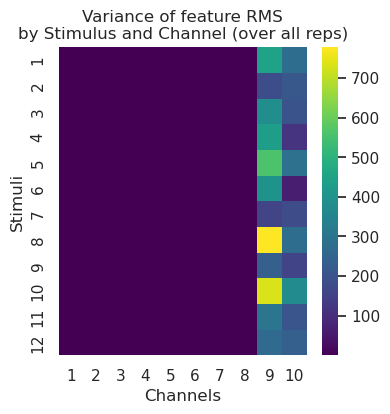

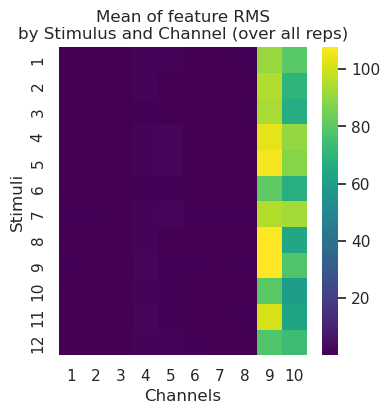


Top 3 combinations with highest variability for feature 'WL':
1. Stimulus 1, Channel 10, Variance: 1063.6500
2. Stimulus 1, Channel 9, Variance: 732.7600
3. Stimulus 8, Channel 10, Variance: 488.2900


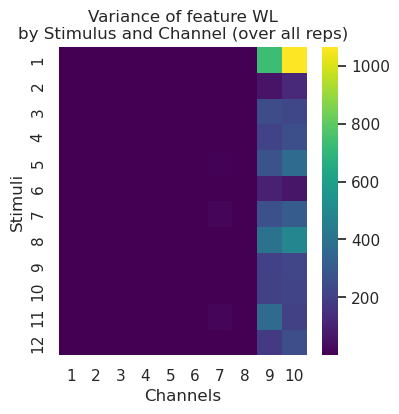

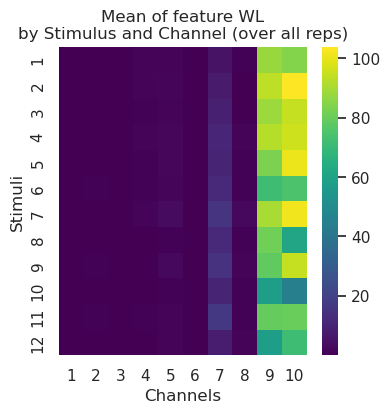


Top 3 combinations with highest variability for feature 'SSC':
1. Stimulus 8, Channel 9, Variance: 621.7600
2. Stimulus 1, Channel 9, Variance: 427.4400
3. Stimulus 10, Channel 10, Variance: 328.0100


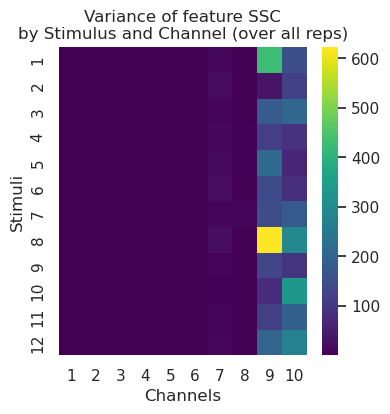

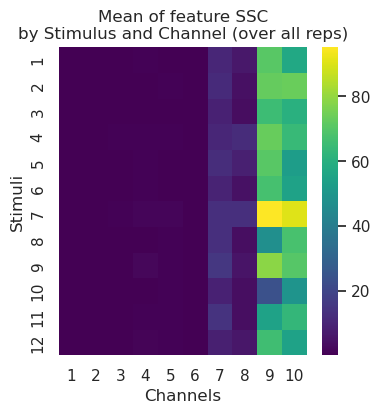


4 combinations (Stimulus, Channel) with highest variability in all features overall:
1. Stimulus 1, Channel 9, appears 3 times
2. Stimulus 7, Channel 10, appears 2 times
3. Stimulus 12, Channel 10, appears 2 times
4. Stimulus 10, Channel 9, appears 2 times


In [14]:
# build the full dataset before splitting, to analyze all stimuli and repetitions
n_stimuli = 12
n_repetitions = 10
n_channels = emg.shape[1]
n_features = len([mav, std, maxav, rms, wl, ssc])

# Build the full dataset (all stimuli & repetitions) from all_samples
full_dataset, full_labels = build_dataset_from_ninapro(
    emg=emg,
    stimulus=stimulus,
    repetition=repetition,
    features=[mav, std, maxav, rms, wl, ssc]
)

reshaped_data = full_dataset.reshape((n_stimuli, n_repetitions, n_channels, n_features))

feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]
top_combinations = []

# Compute variance and mean for each feature across repetitions
for feature_idx, feature_name in enumerate(feature_names):
    variance_matrix = np.zeros((n_stimuli, n_channels))
    mean_matrix = np.zeros((n_stimuli, n_channels))
    
    for i in range(n_stimuli):
        for j in range(n_channels):
            # Variance across the 10 repetitions for a given stimulus and channel
            variance_matrix[i, j] = np.var(reshaped_data[i, :, j, feature_idx])
            mean_matrix[i, j] = np.mean(reshaped_data[i, :, j, feature_idx])
    
    # Identify top 3 (stimulus, channel) combinations with highest variability
    top_indices = np.dstack(np.unravel_index(np.argsort(-variance_matrix.ravel()), variance_matrix.shape))[0][:3]
    top_combinations.extend([tuple(idx) for idx in top_indices])
    
    # Print top 3 combinations
    print(f"\nTop 3 combinations with highest variability for feature '{feature_name}':")
    for rank, (stim_idx, chan_idx) in enumerate(top_indices):
        print(f"{rank+1}. Stimulus {stim_idx+1}, Channel {chan_idx+1}, Variance: {variance_matrix[stim_idx, chan_idx]:.4f}")
    
    # Heatmap for variance
    plt.figure(figsize=(4,4))
    sns.heatmap(variance_matrix, annot=False, fmt=".2f", cmap="viridis",
                xticklabels=[f"{c+1}" for c in range(n_channels)],
                yticklabels=[f"{s+1}" for s in range(n_stimuli)])
    plt.title(f"Variance of feature {feature_name}\nby Stimulus and Channel (over all reps)")
    plt.xlabel("Channels")
    plt.ylabel("Stimuli")
    plt.show()
    
    # Heatmap for mean
    plt.figure(figsize=(4,4))
    sns.heatmap(mean_matrix, annot=False, fmt=".2f", cmap="viridis",
                xticklabels=[f"{c+1}" for c in range(n_channels)],
                yticklabels=[f"{s+1}" for s in range(n_stimuli)])
    plt.title(f"Mean of feature {feature_name}\nby Stimulus and Channel (over all reps)")
    plt.xlabel("Channels")
    plt.ylabel("Stimuli")
    plt.show()

# Count the frequency of each (stimulus, channel) combination across all features
combination_counter = Counter(top_combinations)

# Get the top 4 most frequent combinations
most_common_combinations = combination_counter.most_common(4)

print("\n4 combinations (Stimulus, Channel) with highest variability in all features overall:")
for rank, ((stim_idx, chan_idx), count) in enumerate(most_common_combinations):
    print(f"{rank+1}. Stimulus {stim_idx+1}, Channel {chan_idx+1}, appears {count} times")

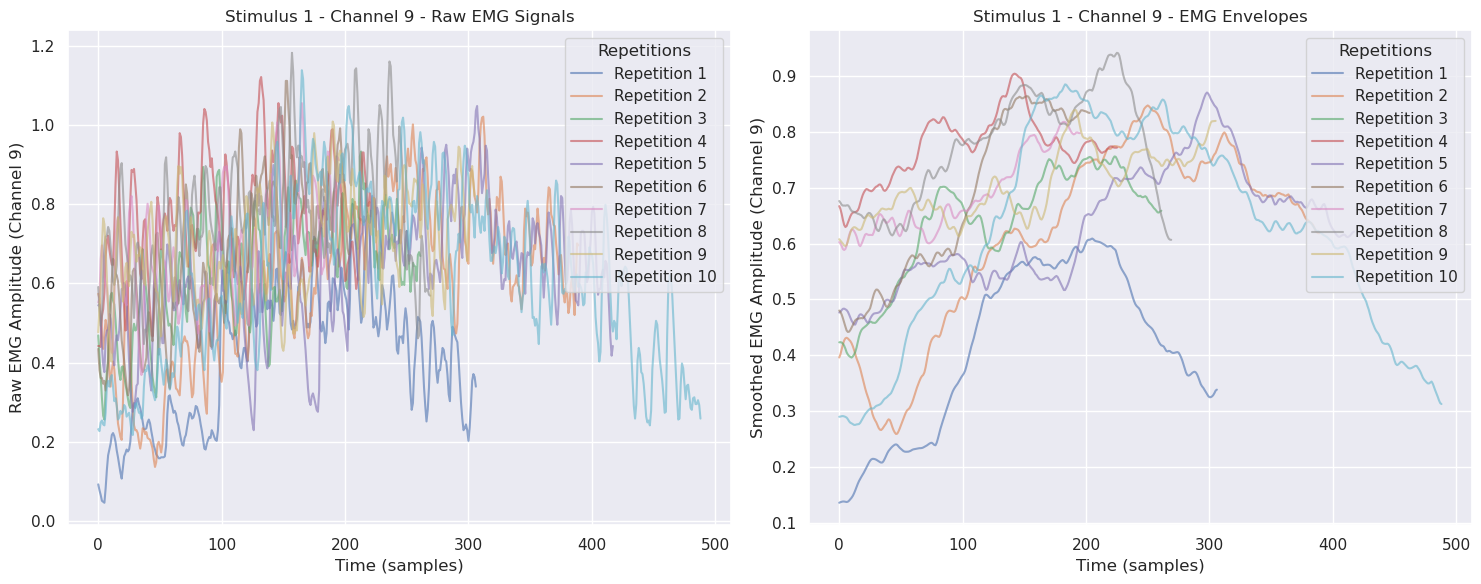

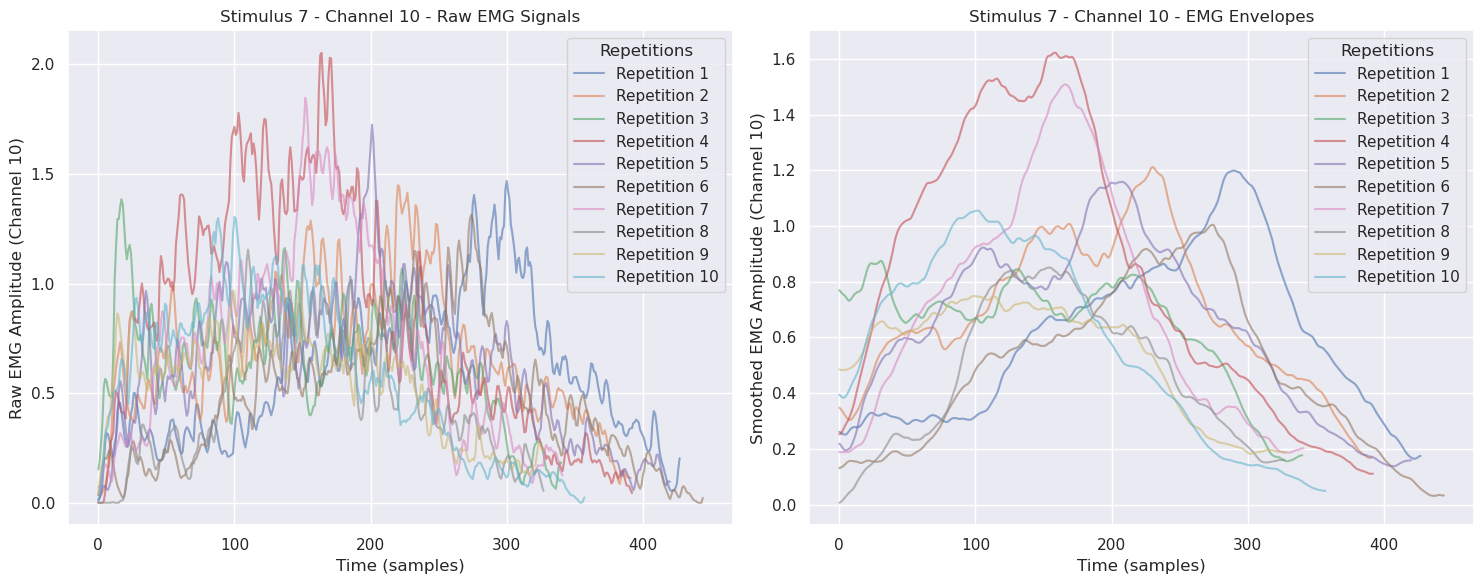

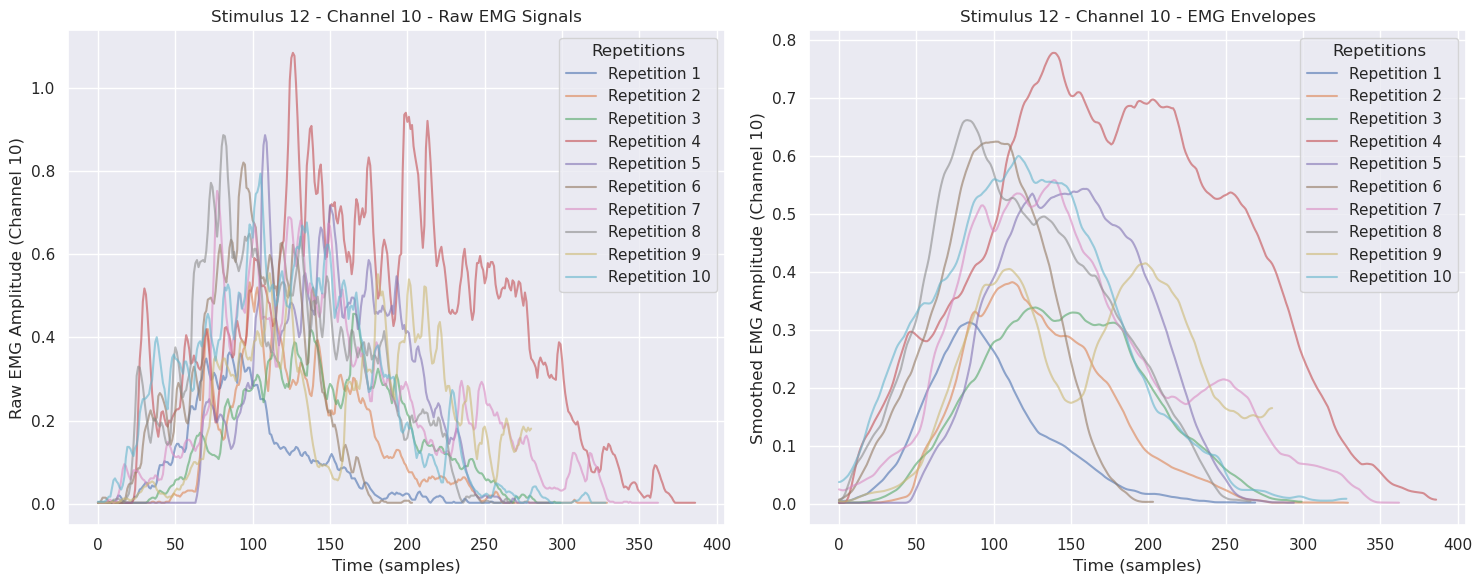

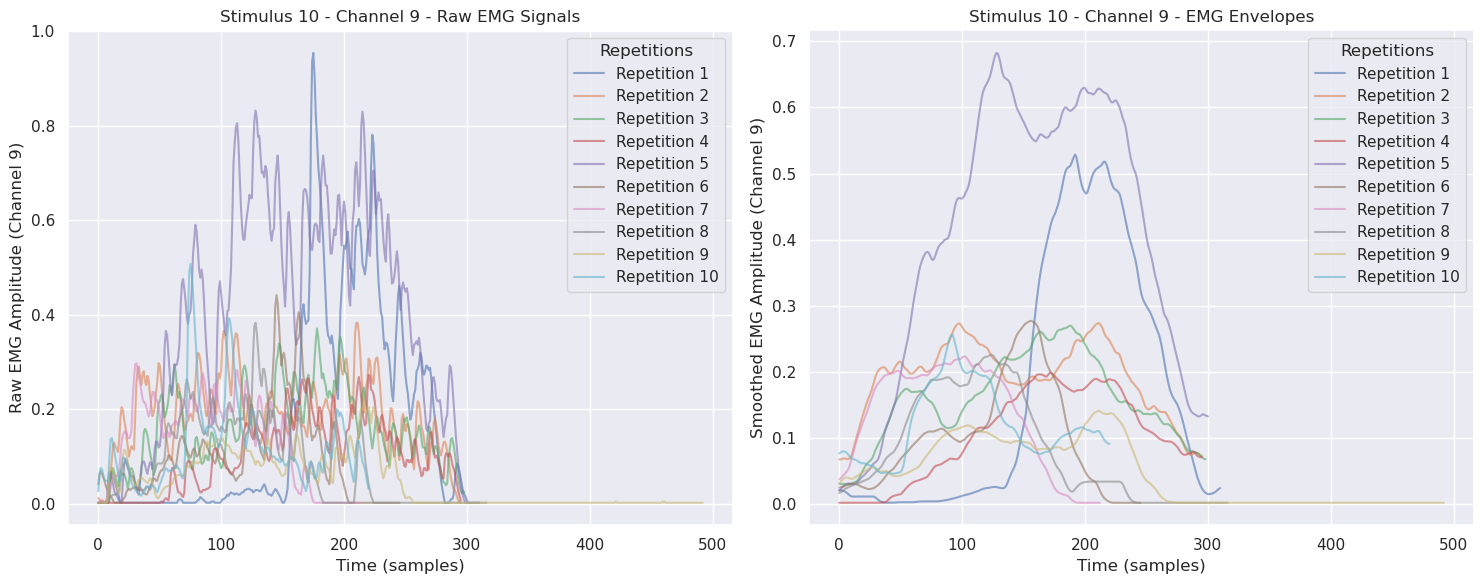

In [15]:
# look at the signals for the combinations of stimulus, channel with highest variance
tuples_list = [(1,9), (7, 10), (12, 10), (10, 9)]
plot_emg_and_envelopes(emg_windows, emg_envelopes, tuples_list, n_repetitions)


Indeed we see that the signals are quite variable, which might explain the discrepancies in the features. The variability both lies in the amplitude of the signals and in their duration. Howerver, it does not seem that there are really 'bad' trials, so we decided to not remove any of them.

# 4. Train classification model

In [16]:
# Hyperparameter Optimization for GradientBoostingClassifier
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gbc = GradientBoostingClassifier(random_state=42)

# GridSearchCV for hyperparameter optimization
grid_search = GridSearchCV(
    estimator=gbc,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

# Best parameters and model
print("\nBest Hyperparameters Found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   5.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=200

# 6. Evaluation of model performance


Test Performance:
Accuracy: 0.7222
Classification Report:
              precision    recall  f1-score   support

         1.0       0.60      1.00      0.75         3
         2.0       0.60      1.00      0.75         3
         3.0       0.67      0.67      0.67         3
         4.0       1.00      0.67      0.80         3
         5.0       1.00      0.67      0.80         3
         6.0       0.00      0.00      0.00         3
         7.0       1.00      1.00      1.00         3
         8.0       0.50      0.67      0.57         3
         9.0       0.67      0.67      0.67         3
        10.0       1.00      1.00      1.00         3
        11.0       1.00      1.00      1.00         3
        12.0       0.33      0.33      0.33         3

    accuracy                           0.72        36
   macro avg       0.70      0.72      0.69        36
weighted avg       0.70      0.72      0.69        36

Confusion Matrix:


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Text(0.5, 19.049999999999997, 'Predicted label')

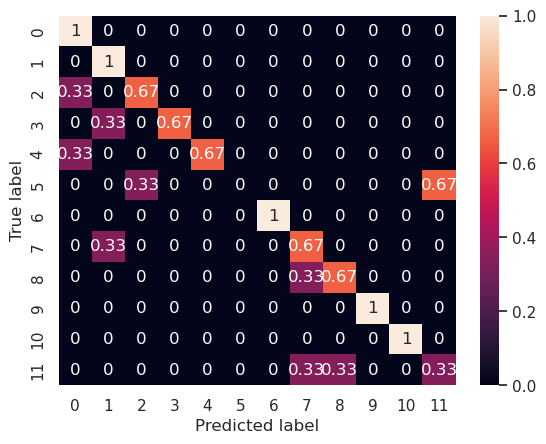

In [17]:
# Evaluate on Test Set
y_test_pred = best_model.predict(X_test)
print("\nTest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
print("Confusion Matrix:")
confmat = confusion_matrix(y_test, y_test_pred, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)  # Use seaborn to create a heatmap of the confusion matrix
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")


# 7. Feature selection / dimension reduction

Estimated mutual information between each feature and the target:
 [0.66350888 0.28295023 0.76732893 0.79526704 0.80950531 0.58788167
 0.6257603  0.69980132 0.79311283 0.70421099 0.82911992 0.32778209
 0.76669994 0.85352278 0.75592697 0.59940356 0.66652059 0.78241325
 0.86479075 0.72705353 0.78567393 0.40200968 0.61704571 0.83963324
 0.65849841 0.56549193 0.60102877 0.68753056 0.745005   0.72837293
 0.73047441 0.31511732 0.74212765 0.81405652 0.75315054 0.62753618
 0.64276486 0.68041597 0.81263163 0.74385341 0.49928529 0.14118537
 0.80148867 0.97004984 0.90115774 0.77221507 0.59030188 0.67122278
 0.81812649 0.76563508 0.12899041 0.08357162 0.2132158  0.32998722
 0.81028844 0.50503755 0.47435188 0.19764319 0.37903447 0.22827033]

Accuracy score of a model with k best features: 0.8333333333333334


Text(0.5, 19.049999999999997, 'Predicted label')

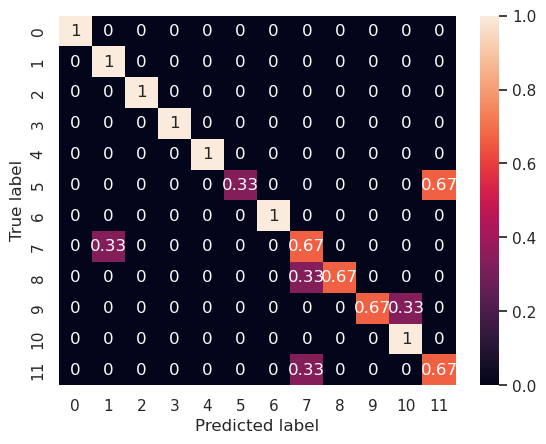

In [18]:
# Calculate mutual information between each feature and the target variable.
# Mutual information is a measure of the dependency between variables.
# A higher value indicates a stronger relationship.
mutual_info = mutual_info_classif(X_train, y_train)
print(f"Estimated mutual information between each feature and the target:\n {mutual_info}\n")

# Select the top 30 features based on mutual information scores.
# Note: You can change 'k' to 10 if you are working with fewer features.
k_best = SelectKBest(mutual_info_classif, k=30)
k_best.fit(X_train, y_train)

# Transform the training and test datasets to only include the selected features.
X_train_best = k_best.transform(X_train)
X_test_best = k_best.transform(X_test)

# initialize the Gradient Boosting model
# use the same 'best hyperparameters as found in previous steps
gb_clf = GradientBoostingClassifier(learning_rate=0.2, max_depth = 3, min_samples_leaf = 4, min_samples_split = 10, n_estimators =100)
                                    
# train model on training data
gb_clf.fit(X_train_best, y_train)

# make predictions with trained model on test data
y_pred = gb_clf.predict(X_test_best)


# Calculate the accuracy of the model with the selected features.
# Accuracy is the ratio of correctly predicted instances to the total instances.
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy score of a model with k best features: {accuracy}")

# Create a confusion matrix to visualize the performance of the classification model.
# The confusion matrix shows the true vs predicted labels.
confmat = confusion_matrix(y_test, y_pred, normalize="true")

# Plot the confusion matrix using a heatmap for better visualization.
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, ax=ax)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted label")


In [20]:
from sklearn.decomposition import PCA

# Method B: PCA

pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

clf_pca = GradientBoostingClassifier()
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
pca_accuracy = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy after PCA (36 components): {pca_accuracy:.4f}")

Accuracy after PCA (36 components): 0.5000
